## Strategy 1 : BANK NIFTY

    step 1: calculate the previous day High (PDH) and previous day low (PDL)
    step 2: Calculate previous day close (PDC)
    step 3: for current day - calculate from first 10 min candle at 9:15 t0 9:25
        1. 10 min high today, H10
        2. 10 min low today,  L10
    step 4: Calculate yesterdays range, RY= PDH - PHL
    step 5: Calculate todays 10 min range, R10 = H10 - L10
    step 6: Sum = RY + R10
    Multiplier, m = 0.618
    step 7: final value, FV = m x Sum

TAKE DECISION NOW  (calculate bb and sb)
    if (either there is gap up or gap down ) then 
    bb = h10 with stop loss for buy = l10
    bl = l10 with stop loss for sell = h10

    Buy Breakout ,bb = PDC  + Final Value 
    Sell Breakout , sb= PDC - Final Value

Stop loss = 0.5% 
    i.e., Buy stop at ---> 0.995 x (Buy Breakout)
    and   Sell Stop at --> 1.005 x (Sell Breakout)

Only 2 Entries a day are required!  <Implemented>
No market enter after 3pm
    



# Now lets 
    1. First take a good stock for backtesting with all anomolies removed!
    2. Write code for`` my Strategy 
    3. Design the whole pipeline for the data and the output.
    4. Save The Results Some Where So That You Can Compare Its Performace With other data sets.
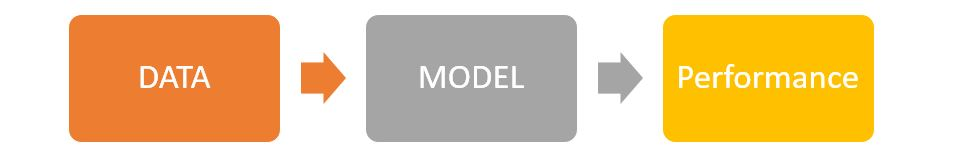

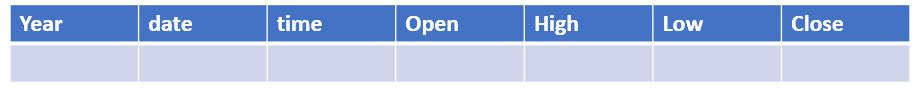

In [57]:
import pandas as pd #To importing data, Processing data,
import numpy as np
from pandas import DataFrame, Series
import datetime
import time

In [58]:
#Read the data
df = pd.read_excel (r'Bank_nifty_data_withformula.xlsx')

In [59]:
df = df.drop(['Unnamed: 13','Unnamed: 14'],axis = 1)

In [15]:
df

,start_date,start_time,open,high,low,close,volume
0,2015-01-01,09:16:00,18861,18868,18807,18810,23225
1,2015-01-01,09:17:00,18807,18810,18793,18806,26950
2,2015-01-01,09:18:00,18807,18830,18807,18830,14900
3,2015-01-01,09:19:00,18827,18833,18813,18814,8500
4,2015-01-01,09:20:00,18817,18817,18806,18808,11250
...,...,...,...,...,...,...,...
458683,2019-12-31,15:25:00,32372,32387,32370,32385,10720
458684,2019-12-31,15:26:00,32385,32385,32376,32380,6240
458685,2019-12-31,15:27:00,32380,32384,32376,32382,8180
458686,2019-12-31,15:28:00,32382,32384,32380,32380,15240


In [60]:
#Find the PDC (Previous day Close)and PDR (previous day range)
data = pd.DataFrame( columns=['date','pdr','pdc'])
i = 0
j = -1
day = df['start_date'][i]
size = df.shape[0]
while (i<size):
    pdh =df['high'][i]
    pdl =df['low'][i]
    while(i<size and day == df['start_date'][i]):
        pdh = max (pdh,df['high'][i])
        pdl = min (pdl,df['low'][i])
        i+=1
    yr = pdh-pdl
    j+=1
    if i<size:
        day = df['start_date'][i]
        data.loc[j] = [day,yr,df['close'][i-1]]

    

In [61]:
data

,date,pdr,pdc
0,2015-01-02,155,18916
1,2015-01-05,367,19254
2,2015-01-06,171,19146
3,2015-01-07,549,18498
4,2015-01-08,286,18449
...,...,...,...
1220,2019-12-24,205,32337
1221,2019-12-26,114,32305
1222,2019-12-27,394,31999
1223,2019-12-30,387,32616


In [62]:
df['start_time'][1]

datetime.time(9, 17)

In [116]:
result = pd.DataFrame( columns=['date','trade','timeT','priceT','timeE','priceE','Stop Loss','Profit'])
#We have to start form 2nd day of the data only.
i = 0
day = df['start_date'][i]
while (day==df['start_date'][i]):
    i+=1
#Now we are at an index to 2nd day.
j = 0
k=-1
day = df['start_date'][i]
size = df.shape[0]

while (i<size):
    to = df['open'][i] #todays open
    h10 =df['high'][i]
    l10 =df['low'][i]
    while(df['start_time'][i] < datetime.time(9, 26)):
        h10 = max (h10,df['high'][i])
        l10 = min (l10,df['low'][i])
        i+=1
    k+=1
    #///////////////////////////////////////////////////////////////     Gap up or Gap Down
    if(to > data['pdc'][k]*1.01 or to < data['pdc'][k]*0.99):
        bb = h10
        sb = l10
        pl = 0
        
        entry = 1 #To ensure maximum Two entries a day
        while(i<size and df['start_date'][i]==day): #trade in rest of the day
            #Search for the candle to enter
            if (entry<=2 and df['start_time'][i]<datetime.time(15, 0) and df['high'][i] >= bb): #Enter now for BUY and if time < 3pm
                trade = 'long'
                entertime = df['start_time'][i]
                i += 1
                entry += 1
                while (i<size and df['start_time'][i]<= datetime.time(15, 15)) and (df.iat[i,4] > sb): #aage bdo
                    i = i + 1
                if (i==size or df['start_time'][i]> datetime.time(15, 15)):
                    pl = pl + df['close'][i-1] - bb
                    i=i-1
                    result.loc[j] = [day,trade,entertime,bb,df['start_time'][i],df['close'][i],sb,pl]
                    j+=1
                    pl=0
                else:
                    pl = pl + sb - bb
                    result.loc[j] = [day,trade,entertime,bb,df['start_time'][i],sb,sb,pl]
                    j+=1
                    pl=0
                    
            
            if (entry<=2 and df['start_time'][i]<datetime.time(15, 0) and df['low'][i] <= sb): #Enter now for SELL and if time <3pm
                trade = 'short'
                entertime = df['start_time'][i]
                i+=1
                entry += 1
                while i<size and df.loc[i]['high'] < bb and df['start_time'][i]<= datetime.time(15, 15):# aage bdo
                    i+=1
                if(i==size or df['start_time'][i]> datetime.time(15, 15)):
                    pl = pl + sb - df['close'][i-1]
                    i-=1
                    result.loc[j] = [day,trade,entertime,sb,df['start_time'][i],df['close'][i],bb,pl]
                    j+=1
                    pl=0
                else:
                    pl = pl + sb - bb
                    result.loc[j] = [day,trade,entertime,sb,df['start_time'][i],bb,bb,pl]
                    j+=1
                    pl=0
            i+=1 #enter the next day
        if i<size:
            day = df['start_date'][i]
        
     #/////////////////////////////////////////////////////////////////// Otherwise   
    else:
        #Calculate the required.
        m  = 0.618
        bb = data['pdc'][k] + m*(data['pdr'][k] + h10-l10)
        sb = data['pdc'][k] - m*(data['pdr'][k] + h10-l10)
        pl = 0 #profit loss = 0 by default for a day
    
        entry = 1 #To ensure maximum Two entries a day
        while(i<size and df['start_date'][i]==day): #trade in rest of the day
            #Search for the candle to enter
            if (entry<=2 and df['start_time'][i]<=datetime.time(15, 0) and df['high'][i] >= bb): #Enter now for BUY and if time < 3pm
                trade = 'long'
                price = df['high'][i]
                entertime = df['start_time'][i]
                i += 1
                entry += 1
                while (i<size and df['start_time'][i]<= datetime.time(15, 15)) and (df.iat[i,4] > 0.995*bb): #aage bdo
                    i = i + 1
                if (i==size or df['start_time'][i]>datetime.time(15, 15) ):
                    pl = pl + df['close'][i-1] - bb-4
                    i=i-1
                    result.loc[j] = [day,trade,entertime,bb,df['start_time'][i],df['close'][i],0.995*bb,pl]
                    j+=1
                    pl=0
                else:
                    pl = pl + 0.995*bb - bb-4
                    result.loc[j] = [day,trade,entertime,bb,df['start_time'][i],0.995*bb,0.995*bb,pl]
                    j+=1
                    pl=0
                    
            
            if (entry<=2 and df['start_time'][i]<datetime.time(15, 0) and df['low'][i] <= sb): #Enter now for SELL and if time <3pm
                trade = 'short'
                price = df['low'][i]
                entertime = df['start_time'][i]
                i+=1
                entry += 1
                while i<size and df.loc[i]['high'] < 1.005*sb and df['start_time'][i]<= datetime.time(15, 15):# aage bdo
                    i+=1
                if(i==size or df['start_time'][i]>datetime.time(15, 15)):
                    pl = pl + sb - df['close'][i-1]-4
                    i-=1
                    result.loc[j] = [day,trade,entertime,sb,df['start_time'][i],df['close'][i],1.005*sb,pl]
                    j+=1
                    pl=0
                else:
                    pl = pl + sb - 1.005*sb-4
                    result.loc[j] = [day,trade,entertime,sb,df['start_time'][i],1.005*sb,1.005*sb,pl]
                    j+=1
                    pl=0
            i+=1 #enter the next day
        if i<size:
            day = df['start_date'][i]

In [117]:
result

,date,trade,timeT,priceT,timeE,priceE,Stop Loss,Profit
0,2015-01-02,long,09:42:00,19056.904,15:15:00,19196,18961.61948,135.09600
1,2015-01-06,short,09:26:00,18956.892,15:15:00,18508,19051.67646,444.89200
2,2015-01-08,short,09:29:00,18590.000,14:11:00,18733,18733.00000,-143.00000
3,2015-01-08,long,14:12:00,18733.000,15:15:00,18779,18590.00000,46.00000
4,2015-01-09,short,12:39:00,18562.936,12:53:00,18655.8,18655.75068,-96.81468
...,...,...,...,...,...,...,...,...
596,2019-12-06,short,14:08:00,31374.594,15:15:00,31414,31531.46697,-43.40600
597,2019-12-12,long,14:08:00,31612.650,15:15:00,31725,31454.58675,108.35000
598,2019-12-13,long,10:11:00,32007.370,15:15:00,32113,31847.33315,101.63000
599,2019-12-26,short,11:50:00,32169.040,15:15:00,32013,32329.88520,152.04000


In [119]:
result.to_excel( r'FResult_S1.xlsx',sheet_name= 'Test 1')

In [120]:
result['year'] = pd.DatetimeIndex(result['date']).year
result['month']=pd.DatetimeIndex(result['date']).month

In [121]:
result

,date,trade,timeT,priceT,timeE,priceE,Stop Loss,Profit,year,month
0,2015-01-02,long,09:42:00,19056.904,15:15:00,19196,18961.61948,135.09600,2015,1
1,2015-01-06,short,09:26:00,18956.892,15:15:00,18508,19051.67646,444.89200,2015,1
2,2015-01-08,short,09:29:00,18590.000,14:11:00,18733,18733.00000,-143.00000,2015,1
3,2015-01-08,long,14:12:00,18733.000,15:15:00,18779,18590.00000,46.00000,2015,1
4,2015-01-09,short,12:39:00,18562.936,12:53:00,18655.8,18655.75068,-96.81468,2015,1
...,...,...,...,...,...,...,...,...,...,...
596,2019-12-06,short,14:08:00,31374.594,15:15:00,31414,31531.46697,-43.40600,2019,12
597,2019-12-12,long,14:08:00,31612.650,15:15:00,31725,31454.58675,108.35000,2019,12
598,2019-12-13,long,10:11:00,32007.370,15:15:00,32113,31847.33315,101.63000,2019,12
599,2019-12-26,short,11:50:00,32169.040,15:15:00,32013,32329.88520,152.04000,2019,12


AxesSubplot(0.125,0.125;0.775x0.755)


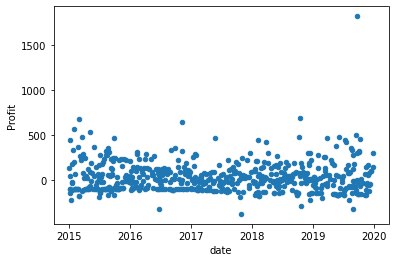

In [122]:
ax = result.plot.scatter(x= 'date', y='Profit')
print(ax)

In [123]:
#year wise result 'yresult'

In [124]:
mresult = pd.DataFrame(columns = ['year','month','total pl'])
i = 0
j = -1
size = result.shape[0]
year = (result['year'][i])
month = (result['month'][i])
while(i<size):
    total = 0
    while (i<size) and (result['month'][i]) == month:
        total = total + result['Profit'][i]
        i +=1
    j += 1
    mresult.loc[j] = [year,month,total]
    month= month +1
    if (month == 13):
        year = year + 1 
        month = 1

In [125]:
mresult

,year,month,total pl
0,2015.0,1.0,1004.13959
1,2015.0,2.0,-51.94057
2,2015.0,3.0,1433.88600
3,2015.0,4.0,-9.73345
4,2015.0,5.0,527.10826
5,2015.0,6.0,216.52266
6,2015.0,7.0,410.35989
7,2015.0,8.0,73.61358
8,2015.0,9.0,1152.09666
9,2015.0,10.0,-226.72890


In [126]:
yresult = pd.DataFrame(columns = ['year','total pl'])
i = 0
j = -1
size = mresult.shape[0]
year = (mresult['year'][i])
while(i<size):
    total = 0
    while (i<size) and (mresult['year'][i]) == year:
        total = total + mresult['total pl'][i]
        i +=1
    j += 1
    yresult.loc[j] = [year,total]
    year = year + 1

In [127]:
yresult

,year,total pl
0,2015.0,5070.80233
1,2016.0,4217.43554
2,2017.0,999.52035
3,2018.0,4052.34172
4,2019.0,5187.22550


## Then we have  to find DropDown and Cumulative PnL in Excel Sheet 
## And finally calculate the CALMAR ratio = Total Profit / (no of years * max DrawDown)